In [3]:
import os
import numpy as np
import xray
from scipy.ndimage.measurements import center_of_mass
from shutil import copyfile
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.basemap import Basemap
import seaborn as sns
sns.set_style("whitegrid")

from netCDF4 import Dataset
from datetime import datetime
import cdo

from collections import OrderedDict
from itertools import islice

fill_val = -9999

In [4]:
# Input Files
rasm_mask_file = '/Users/jhamman/Dropbox/src/rasm/scripts/rasm_utils/Post_processing/fluxes/RASM_WRFVIC_GRID_MASKS_AND_METRICS.nc'
domain_file = '/Users/jhamman/Dropbox/RASM_Joe/domain.lnd.wr50a_ar9v4.100920.nc'
ocean_domain_file = '/Users/jhamman/Dropbox/RASM_Joe/rasm_masks/domain.ocn.ar9v4.100920.nc'
ecoregions = '/Users/jhamman/Dropbox/RASM_Joe/rasm_masks/tnc_wwf_mhtnam_ecoregions.nc'

rvic_param_file = '/Users/jhamman/workdir/p2.2b.rvic.prm.wr50a.20131003.nc'

ocn_mask_file = '/Users/jhamman/Dropbox/src/rasm/scripts/rasm_utils/Post_processing/fluxes/RASM_POPCICE_GRID_MASKS_AND_METRICS.nc'
r2o_map_file = '/Users/jhamman/Dropbox/RASM_Joe/rasm_masks/map_wr50a_to_ar9v4_nnsm_e1000r300_130508.nc'

today = datetime.now()
new_mask_file = today.strftime('/Users/jhamman/workdir/rasm_land_masks.%Y%m%d.nc')

In [5]:
projection = {'urcrnrlat': 27.511827255753555,
              'urcrnrlon': 16.90845094934209,
              'llcrnrlat': 16.534986367884521,
              'llcrnrlon': 189.2229322311162,
              'projection': 'lcc',
              'rsphere': 6371200.0,
              'lon_0': -114,
              'lat_0': 90}

def sub_plot_pcolor(lons, lats, data, title=None, cmap='Spectral_r',
                    vmin=None, vmax=None, cbar=True, cbar_location='bottom',
                    units=None, projection=None):

    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()

    if projection is None:
        projection = {'urcrnrlat': 27.511827255753555,
                      'urcrnrlon': 16.90845094934209,
                      'llcrnrlat': 16.534986367884521,
                      'llcrnrlon': 189.2229322311162,
                      'projection': 'lcc',
                      'rsphere': 6371200.0,
                      'lon_0': -114,
                      'lat_0': 90}

    m = Basemap(**projection)
    xi, yi = m(np.squeeze(lons), np.squeeze(lats))
    sp = m.pcolormesh(xi, yi, np.squeeze(data),
                      vmin=vmin, vmax=vmax, cmap=cmap)
    m.drawparallels(np.arange(-80., 81., 20.))
    m.drawmeridians(np.arange(-180., 181., 20.))
    m.drawcoastlines(color='k', linewidth=0.25)

    if title:
        plt.title(title, size=13)
    if cbar:
        cbar = m.colorbar(location=cbar_location)
    cbar.set_label(units)

    return sp

def plot2masks(lndmask, ocnmask, title=''):

    fig, ax = plt.subplots()

    m = Basemap(ax=ax, **projection)
    xi, yi = m(np.squeeze(domain['xc'].values), np.squeeze(domain['yc'].values))
    sp = m.pcolormesh(xi, yi, np.ma.masked_where(lndmask == 0,
                                                 lndmask),
                      cmap='Spectral_r', vmin=0)

    m.colorbar(mappable=sp)

    xi, yi = m(np.squeeze(ocn_masks['ULON'].values), np.squeeze(ocn_masks['ULAT'].values))
    sp = m.pcolormesh(xi, yi, np.ma.masked_where(ocnmask == 0,
                                                 ocnmask),
                      cmap='Greys', vmin=0, vmax=2)

    m.drawparallels(np.arange(-80., 81., 20.))
    m.drawmeridians(np.arange(-180., 181., 20.))
    m.drawcoastlines(color='k', linewidth=0.25)

    ax.set_title(title)

In [6]:
rasm_data = xray.open_dataset(rasm_mask_file)
ocn_masks = xray.open_dataset(ocn_mask_file)
domain = xray.open_dataset(domain_file)
r2omap = xray.open_dataset(r2o_map_file)
eco_masks = xray.open_dataset(ecoregions)
ocn_domain = xray.open_dataset(ocean_domain_file)

In [7]:
# rasm coord vars
rasm_lats = rasm_data['latitude'].values
rasm_lons = rasm_data['longitude'].values
rasm_land_mask = np.logical_not(rasm_data['mask'].values).astype(np.int)
rasm_land_y, rasm_land_x = np.nonzero(rasm_land_mask)
rasm_land_lats = rasm_lats[rasm_land_y, rasm_land_x]
rasm_land_lons = rasm_lons[rasm_land_y, rasm_land_x]

In [8]:
rvic_param = xray.open_dataset(rvic_param_file, decode_cf=False)

Largest Drainage Basins
============

In [9]:
basins = OrderedDict()
for outlet in rvic_param['outlet_number'].values:
    basins[outlet] = (rvic_param['source2outlet_ind'].values == outlet).sum()

In [11]:
basin_names = {3220: 'Amur',
               4535: 'Ob',
               4117: 'Yenisey',
               2968: 'Lena',
               991: 'Mackenzie',
               119: 'Nelson',
               70: 'St. Lawrence',
               1300: 'Yukon',
               2467: 'Kolyma',}

In [12]:
main_mask = np.zeros_like(rasm_land_mask) - 999

basin_masks = OrderedDict()

nbasins = 9
for outlet in list(islice(basins, nbasins)):    
    inds = (rvic_param['source2outlet_ind'].values == outlet)
    ys = rvic_param['source_y_ind'].values[inds]
    xs = rvic_param['source_x_ind'].values[inds]
    
    oy = rvic_param['outlet_y_ind'].values[outlet]
    ox = rvic_param['outlet_x_ind'].values[outlet]
    
    source_area = domain['area'].values[ys, xs]
    outlet_area = domain['area'].values[oy, ox]
    
    scale_factors = outlet_area / source_area

    basin_masks[basin_names[outlet]] = np.zeros_like(rasm_land_mask, dtype=float)
    basin_masks[basin_names[outlet]][ys, xs] = rvic_param['unit_hydrograph'].values[:, inds, 0].sum(axis=0) * scale_factors
    
    print(outlet, basin_names[outlet])

3220 Amur
4535 Ob
4117 Yenisey
2968 Lena
991 Mackenzie
119 Nelson
70 St. Lawrence
1300 Yukon
2467 Kolyma


RVIC Drainage Basin
================

In [31]:
rvic_mask = np.zeros(rasm_land_mask.shape)
rvic_frac = np.zeros(rasm_land_mask.shape)

for i, (y,x,cid,uhp) in enumerate(zip(rvic_param['source_y_ind'].values,
                                     rvic_param['source_x_ind'].values,
                                     rvic_param['source_decomp_ind'].values,
                                     rvic_param['unit_hydrograph'].values.sum(axis=0))):
    
    s2o = rvic_param['source2outlet_ind'].values[i]
    oy = rvic_param['outlet_y_ind'].values[s2o]
    ox = rvic_param['outlet_x_ind'].values[s2o]
    
    source_area = rasm_data['cell_area'].values[y, x]
    outlet_area = rasm_data['cell_area'].values[oy, ox]
    
    rvic_mask[y,x] = 1
    rvic_frac[y,x] += uhp.sum() * outlet_area / source_area
    rvic_frac = np.clip(rvic_frac, 0, 1)

Ocean Drainage Basin Masks
==========

In [14]:
debug = False
# Step 0: Unpack a few arrays that we will use.  
lnd_dom_frac = domain['frac'].values
dst_address = r2omap['row'].values - 1  # Move to C indexing
src_address = r2omap['col'].values - 1  # Move to C indexing
remap_weights = r2omap['S'].values * r2omap['area_b'].values[dst_address]

# Handle difference in mapping array and ocean domain sizes
full_dst_shape = r2omap['dst_grid_dims'].values[::-1]
inner_dst_shape = (ocn_masks.dims['y'], ocn_masks.dims['x'])
sub_dst_mask = np.empty(full_dst_shape)

# From @tcraig
# pop figures out the offset on the fly and the ocn.log file says it's 140, 134.
#  ocn_coffset_mct :: x1,y1  =    193.965013544991        24.0210653708509
#  ocn_coffset_mct :: offset =       209181         140         134
# i think that means that i=140, j=134 on the extended grid is i=1, j=1
# on the inner domain.
y0 = 134 -1
y1 = y0 + inner_dst_shape[0]
x0 = 140 - 1
x1 = x0 + inner_dst_shape[1]

if debug:
    # Note that there are differences between the way the coordinates are defined 
    # leading to minor differences in the lat/lon values at the inner corner
    dst_xc = r2omap['xc_b'].values.reshape(full_dst_shape)
    dst_yc = r2omap['yc_b'].values.reshape(full_dst_shape) 

    print(y0, y1, x0, x1)
    print(dst_xc[y0, x0], ocn_masks['ULON'].values[0, 0])
    print(dst_yc[y0, x0], ocn_masks['ULAT'].values[0, 0])
    
    test_mask0 = r2omap['mask_b'].values.reshape(full_dst_shape)

    test_mask0[y0:y1, x0:x1] -= ocn_masks['mask'].values
    plt.figure(figsize=(15,10))
    plt.pcolormesh(test_mask0)
    plt.colorbar()
    
# Step 1: Create 1d index array of rvic outlets
rof_outlet_address = rvic_param['outlet_decomp_ind'].values


mask_archipelago
mask_atlantic
mask_baffin
mask_baltic
mask_barents
mask_bering
mask_canada
mask_centralarctic
mask_denmarkstrait
mask_greenland
mask_hudsonbay
mask_japan
mask_kara
mask_labrador
mask_nansen
mask_northsea
mask_norwegian
mask_okhotsk
mask_pacific
mask_shelf


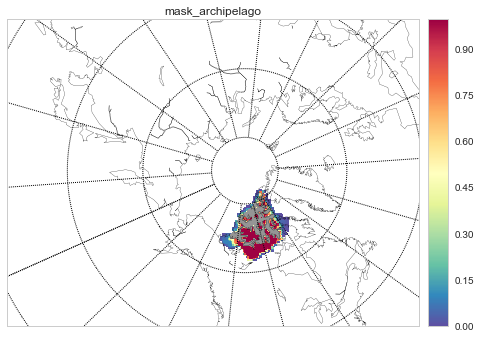

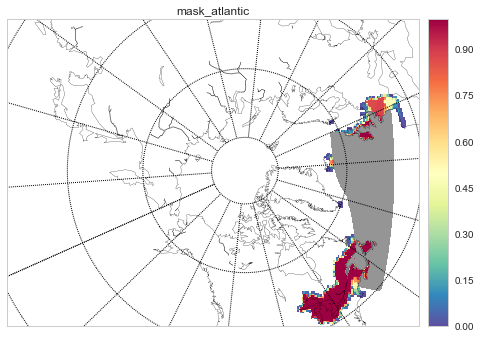

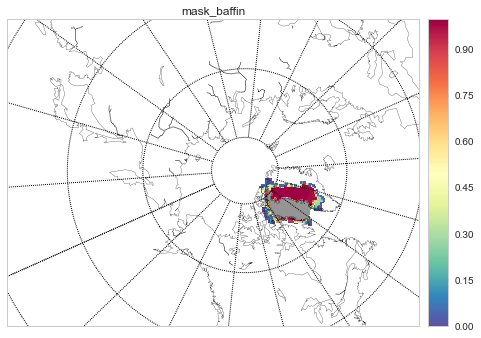

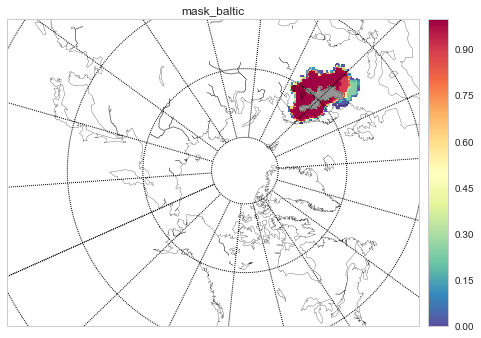

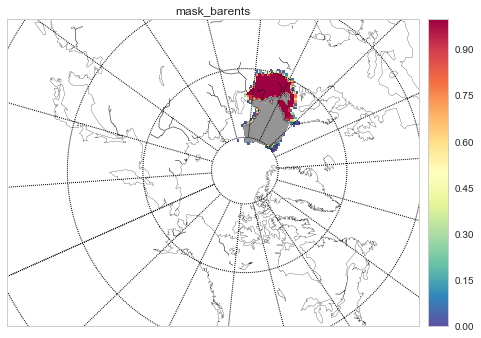

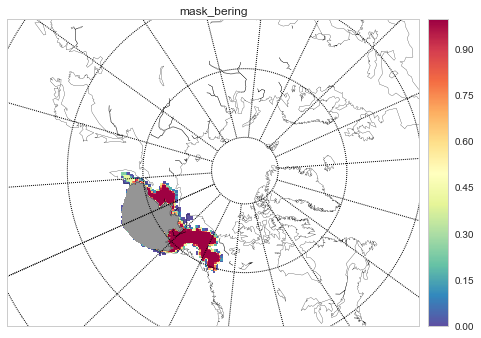

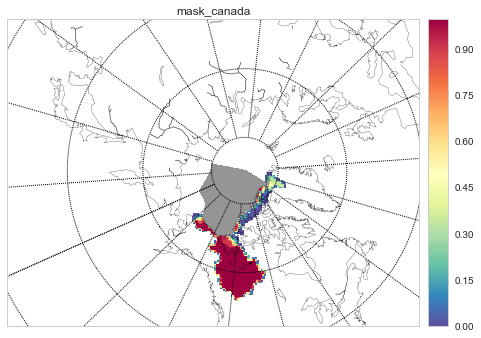

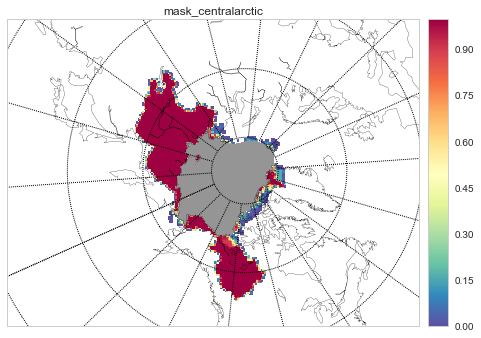

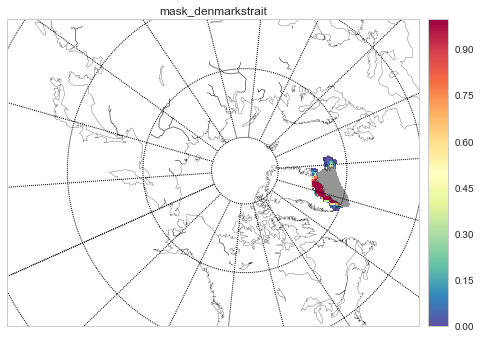

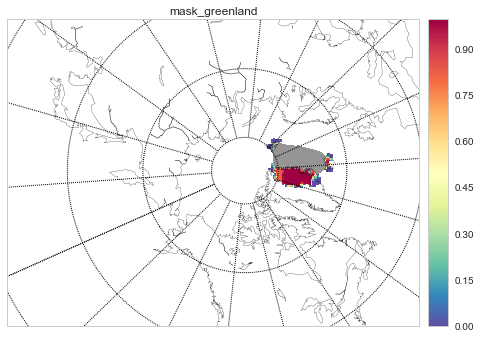

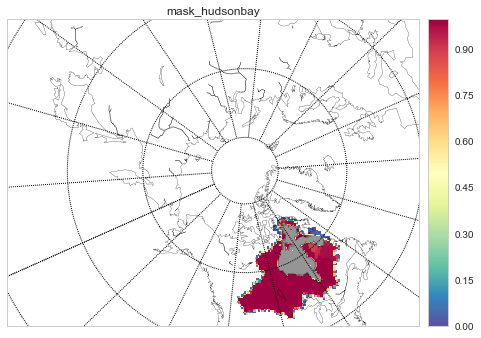

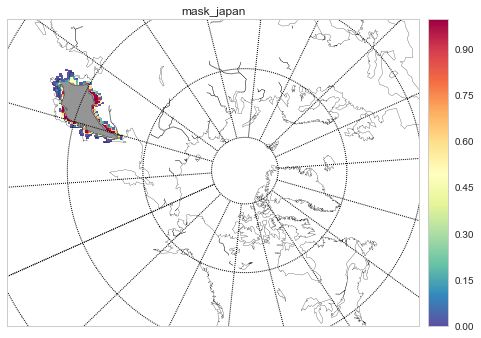

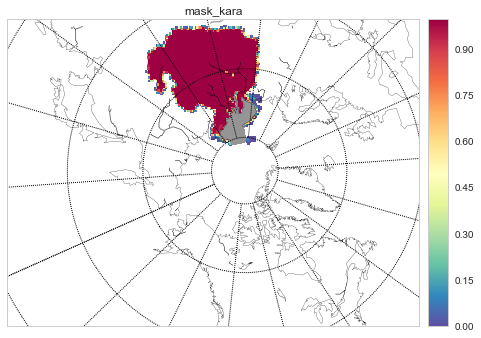

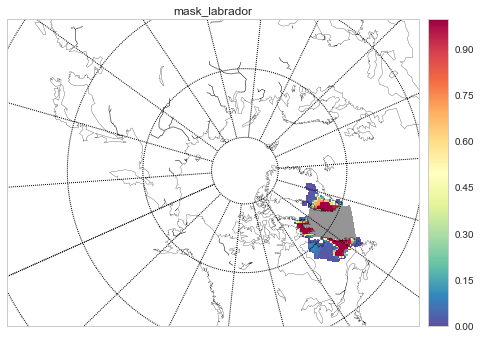

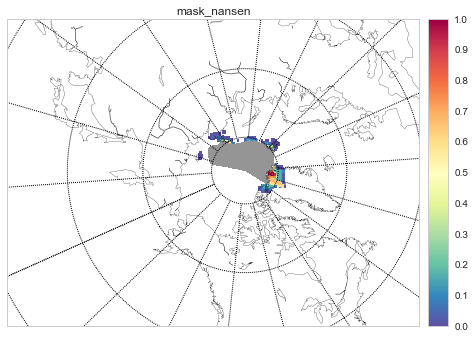

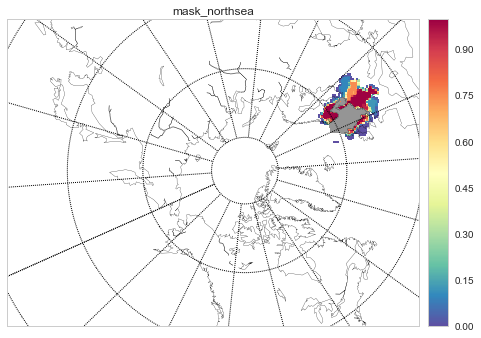

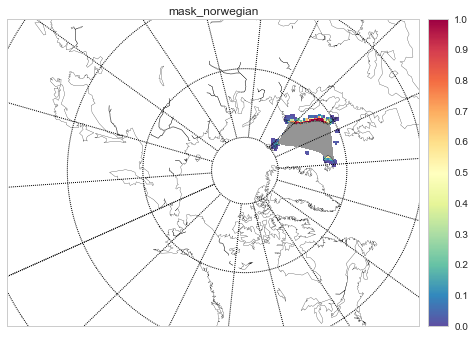

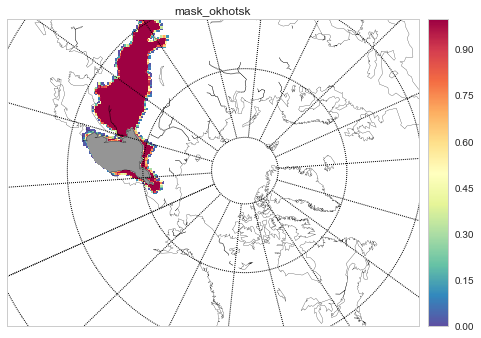

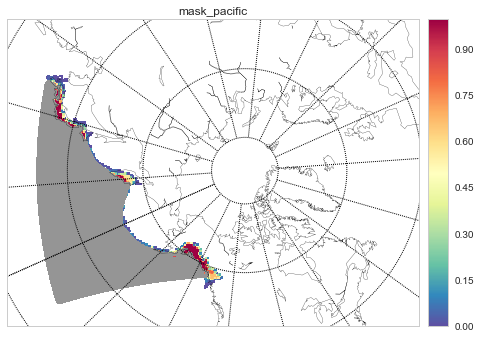

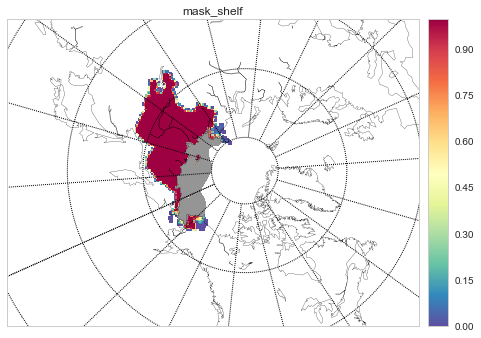

In [15]:
debug = True
# Step 2.  Loop through ocean masks
contrib_area_masks = OrderedDict()

for m in ['mask_archipelago', 'mask_atlantic', 'mask_baffin', 'mask_baltic', 'mask_barents', 
          'mask_bering', 'mask_canada', 'mask_centralarctic', 'mask_denmarkstrait', 'mask_greenland', 
          'mask_hudsonbay', 'mask_japan', 'mask_kara', 'mask_labrador', 'mask_nansen', 
          'mask_northsea', 'mask_norwegian', 'mask_okhotsk', 'mask_pacific', 'mask_shelf']:
    print(m)
    
    contrib_area_masks[m] = np.zeros_like(lnd_dom_frac)
    
    # 2.a Get1d index array of points in dest (ocean) mask
    sub_dst_mask[:, :] = 0
    sub_dst_mask[y0:y1, x0:x1] = ocn_masks[m].values
    sub_dst_address = np.ravel_multi_index(np.nonzero(sub_dst_mask), sub_dst_mask.shape)
    
    # Test that this form of unraveling matches the rvic convention, will raise an AssertionError if it does not
    if debug:
        temp = np.arange(sub_dst_mask.size).reshape(sub_dst_mask.shape)
        test1 = temp[sub_dst_mask > 0]
        np.testing.assert_array_equal(test1, sub_dst_address)
    
    # 2.b Find all source (land) grid cells that map to this dest (ocean) mask
    links = np.in1d(dst_address, sub_dst_address)
    sub_src_address = src_address[links]
    sub_remap_weight = remap_weights[links]
    
    sub_dst_areas = r2omap['area_b'].values[sub_dst_address]
        
    # 2.c Find the land grid cells that are also rof outlets
    sub_rof_src_mask = np.in1d(sub_src_address, rof_outlet_address)
    rof_sub_src_address = sub_src_address[sub_rof_src_mask]
    rof_sub_remap_weight = sub_remap_weight[sub_rof_src_mask]
    
    # 2.d Find the unique land indicies in the masked subset,
    #     Also find the sum of the map weights for each land grid cell
    unq_rof_sub_src_address = np.unique(rof_sub_src_address)
    unq_rof_sub_src_remap_weights = np.zeros_like(unq_rof_sub_src_address, dtype=np.float64)
    for i, address in np.ndenumerate(unq_rof_sub_src_address):
        moi_inds = np.nonzero(address == rof_sub_src_address)[0]
        soi_inds = np.nonzero(address == src_address)[0]
        unq_rof_sub_src_remap_weights[i] = rof_sub_remap_weight[moi_inds].sum() / remap_weights[soi_inds].sum()
    for address, remap_weight in zip(unq_rof_sub_src_address,
                                     unq_rof_sub_src_remap_weights):
        outlet = np.nonzero(address == rof_outlet_address)[0]

        inds = (rvic_param['source2outlet_ind'].values == outlet)
        ys = rvic_param['source_y_ind'].values[inds]
        xs = rvic_param['source_x_ind'].values[inds]

        oy = rvic_param['outlet_y_ind'].values[outlet]
        ox = rvic_param['outlet_x_ind'].values[outlet]

        source_area = domain['area'].values[ys, xs]
        outlet_area = domain['area'].values[oy, ox]

        scale_factors = outlet_area / source_area

        contrib_area_masks[m][ys, xs] += remap_weight * rvic_param['unit_hydrograph'].values[:, inds, 0].sum(axis=0) * scale_factors
    if debug:
        plot2masks(contrib_area_masks[m], ocn_masks[m].values, title=m)

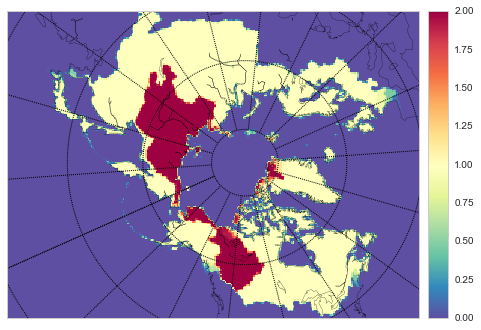

In [16]:
test_sum = np.zeros_like(contrib_area_masks[m])
for m, data in contrib_area_masks.items():
    test_sum += data
    
sub_plot_pcolor(domain['xc'].values, domain['yc'].values, test_sum, units='',
                cbar_location='right')

Biome / Climate Zone Masks
======

In [17]:
# Rearange the biomes mask so each biome is a seperate variable
biome_classes = np.unique(eco_masks['Feature_shp1'].values).astype(np.int)

biome_masks = OrderedDict()
for bc in biome_classes:
    biome_masks[bc] = np.zeros_like(eco_masks['Feature_shp1'].values, dtype=np.float64)
    biome_masks[bc][eco_masks['Feature_shp1'].values == bc] = 1.

In [18]:
remap_again = False
biome_remap_file = 'biomes_wr50a.nc'
if remap_again:
    # write biome_masks to seperate variables in temporary netCDF
    tempfile = 'temp_biomes.nc'
    f = Dataset(tempfile, 'w')

    f.createDimension('lon', size=eco_masks.dims['lon'])
    f.createDimension('lat', size=eco_masks.dims['lat'])

    for coord in ['lon', 'lat']:
        ncvar = f.createVariable(coord, 'f8', dimensions=(coord, ))
        ncvar[:] = eco_masks[coord].values
        ncvar.long_name = eco_masks[coord].long_name
        ncvar.standard_name = eco_masks[coord].standard_name
        ncvar.units = eco_masks[coord].units

    for bc, mask in biome_masks.items():
        ncvar = f.createVariable('biome_{0}'.format(bc), 'f8', dimensions=('lat', 'lon', ))
        ncvar[:] = mask
        ncvar.coordinates = 'lon lat'

    f.close()

    Cdo = cdo.Cdo()
    Cdo.remapcon(domain_file, input=tempfile, output=biome_remap_file)

    os.remove(tempfile)

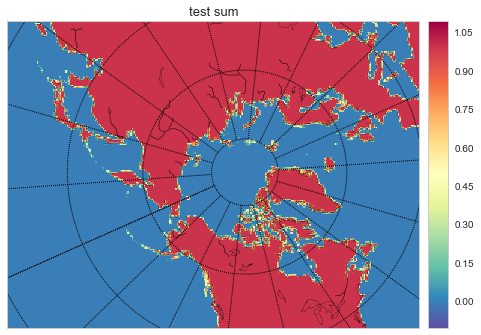

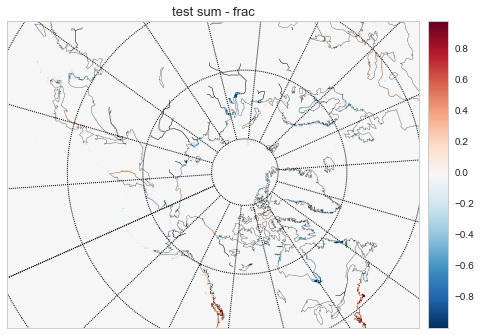

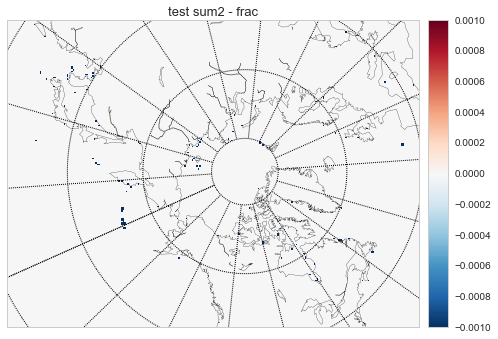

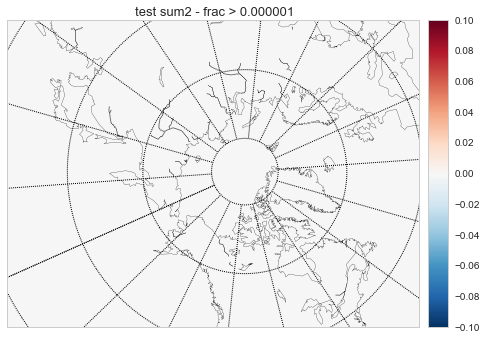

In [19]:
# open the remapped file:
biomes = xray.open_dataset(biome_remap_file)

# Create two arrays used to test and scale the masks
test_sum = np.zeros_like(domain['frac'].values)
test_sum2 = np.zeros_like(domain['frac'].values)

# Only select grid cells that on on the RASM grid
ysf, xsf = np.nonzero(domain['frac'].values)

# First create an array of the sum of all biome classes, we will use this to determine how to adjust 
for bc in biome_classes[biome_classes >= 0]:  # The subset here is ignoring the ocean class
    biome = 'biome_{0}'.format(bc)
    test_sum[ysf, xsf] += np.clip(biomes[biome].values[ysf, xsf], 0., 1.)

# Plot the test sum without any scaling, you'll see a number of grid cells that have positive biases, we'll fix those next
plt.figure()
sub_plot_pcolor(biomes['xc'].values, biomes['yc'].values, 
                test_sum, 
                title='test sum', vmin=-0.1, vmax=1.1,
                cbar_location='right', units='')

plt.figure()
sub_plot_pcolor(biomes['xc'].values, biomes['yc'].values,
                test_sum - domain['frac'].values, 
                title='test sum - frac', cmap='RdBu_r',
                cbar_location='right', units='')

# Scale all masks so they match the fraction array in the domain file
# Note that we are only selecting points where there is a difference between the masks' sum and the domain fractions 
yss, xss = np.nonzero(test_sum != domain['frac'].values)
scale = test_sum[yss, xss] / domain['frac'].values[yss, xss]

# Adjust each biome mask
scaled_biomes = {}
for bc in biome_classes[biome_classes >= 0]:
    biome = 'biome_{0}'.format(bc)
    scaled_biomes[biome] = np.zeros_like(domain['frac'].values)
    scaled_biomes[biome][ysf, xsf] = np.clip(biomes[biome].values[ysf, xsf], 0., 1.)
    scaled_biomes[biome][yss, xss] /= scale
    test_sum2 += np.clip(scaled_biomes[biome], 0., 1.)
    scaled_biomes[biome][scaled_biomes[biome] == np.nan] = 0.

for bc in biome_classes[biome_classes >= 0]:
    biome = 'biome_{0}'.format(bc)
    scaled_biomes[biome][np.isnan(scaled_biomes[biome])] = 0.    
    
plt.figure()
sub_plot_pcolor(biomes['xc'].values, biomes['yc'].values, 
                test_sum2 - domain['frac'].values,
                title='test sum2 - frac', cmap='RdBu_r', vmin=-0.001, vmax=0.001,
                cbar_location='right', units='')

plt.figure()
sub_plot_pcolor(biomes['xc'].values, biomes['yc'].values,
                (test_sum2 - domain['frac'].values) > 0.000001,
                title='test sum2 - frac > 0.000001', cmap='RdBu_r',
                cbar_location='right', units='')

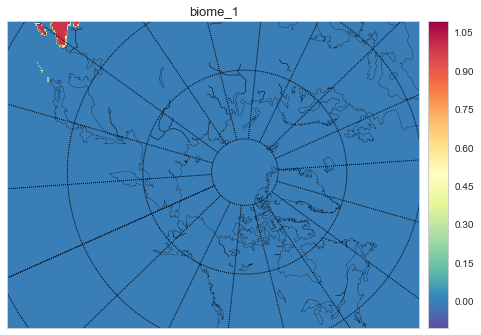

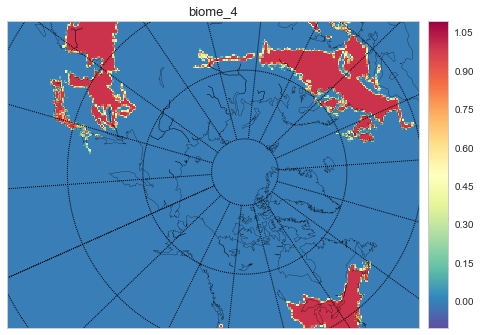

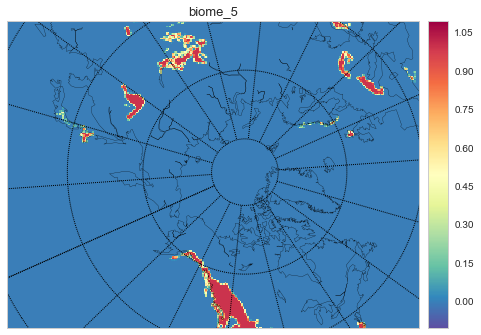

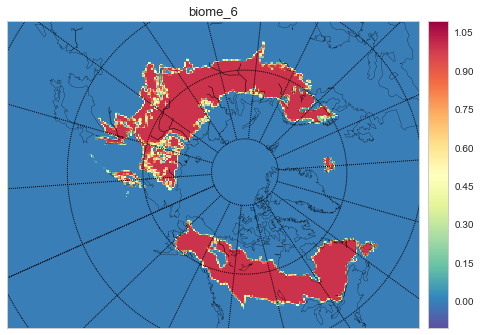

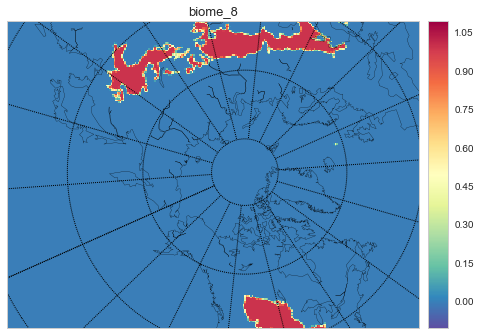

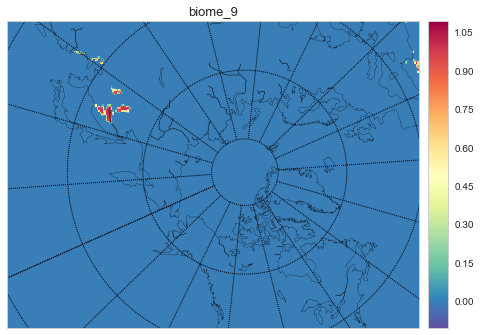

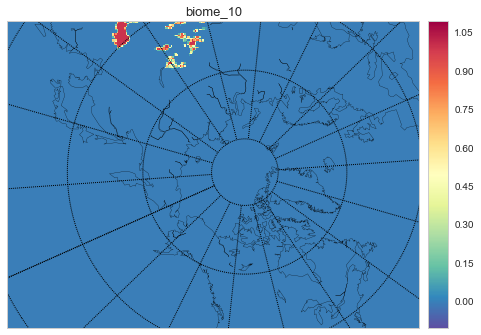

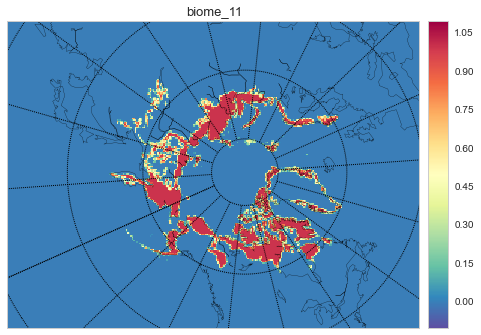

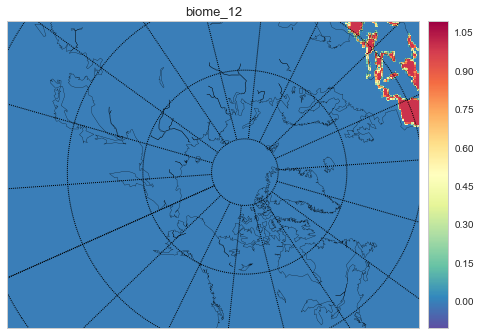

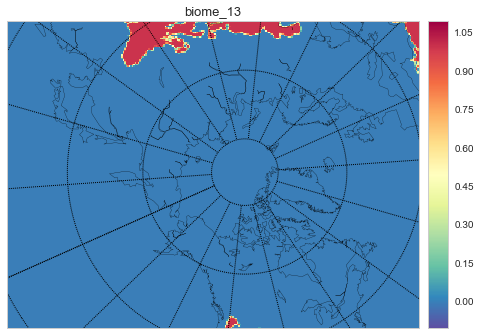

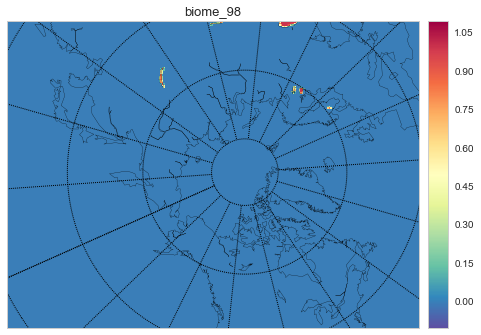

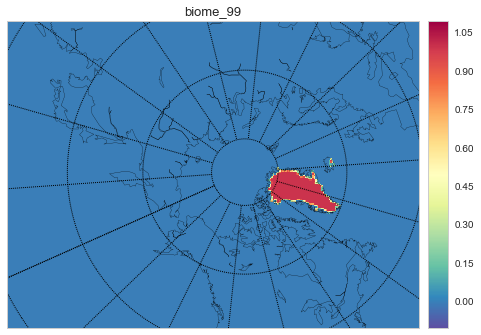

In [20]:
# Finally, plot the individual biomes after the scaling
for bc in biome_classes[biome_classes >= 0]:
    biome = 'biome_{0}'.format(bc)
    if np.nansum(scaled_biomes[biome]) > 1:
        plt.figure()
        sub_plot_pcolor(biomes['xc'].values, biomes['yc'].values, 
                        scaled_biomes[biome], 
                        title=biome, vmin=-0.1, vmax=1.1,
                        cbar_location='right', units='')


In [21]:
ocean_mask_colors = {'01': '#ad3c35',
                     '02': '#2625a2',
                     '03': '#3548ad',
                     '04': '#476bb9',
                     '05': '#5b8ec5',
                     '06': '#70aed0',
                     '07': '#88ccdc',
                     '08': '#bcf3eb',
                     '09': '#bcf3eb',
                     '10': '#d8fff3',
                     '11': '#f7ffd8',
                     '12': '#f1f3bc',
                     '13': '#e7dea1',
                     '14': '#dcc388',
                     '15': '#d0a570',
                     '16': '#c5835b',
                     '17': '#b96047',
                     '18': '#ad3c35',
                     '19': '#a22525',
                     '20': '#961717'}
ocean_mask_names = {'01': 'All of Central Arctic',
                    '02': 'Bering Sea',
                    '03': 'Sea of Okhotsk',
                    '04': 'Sea of Japan',
                    '05': 'Pacific Boundary',
                    '06': 'Kara Sea',
                    '07': 'Barents Sea',
                    '08': 'Norwegian Sea',
                    '09': 'Greenland Sea',
                    '10': 'Denmark Strait and South',
                    '11': 'Labrador Sea',
                    '12': 'Baffin Bay',
                    '13': 'Hudson Bay',
                    '14': 'Canadian Archipelago',
                    '15': 'Baltic Sea',
                    '16': 'North Sea',
                    '17': 'Atlantic Boundary',
                    '18': 'Canada-Makarov Basins',
                    '19': 'Amundsen-Nansen Basins',
                    '20': 'Shelf Area'}
ocean_mask_ncvars = {'mask_centralarctic': '01',
                     'mask_bering': '02',
                     'mask_okhotsk': '03',
                     'mask_japan': '04',
                     'mask_pacific': '05',
                     'mask_kara': '06',
                     'mask_barents': '07',
                     'mask_norwegian': '08',
                     'mask_greenland': '09',
                     'mask_denmarkstrait': '10',
                     'mask_labrador': '11',
                     'mask_baffin': '12',
                     'mask_hudsonbay': '13',
                     'mask_archipelago': '14',
                     'mask_baltic' : '15',
                     'mask_northsea': '16',
                     'mask_atlantic': '17',
                     'mask_canada': '18',
                     'mask_nansen': '19',
                     'mask_shelf': '20'}

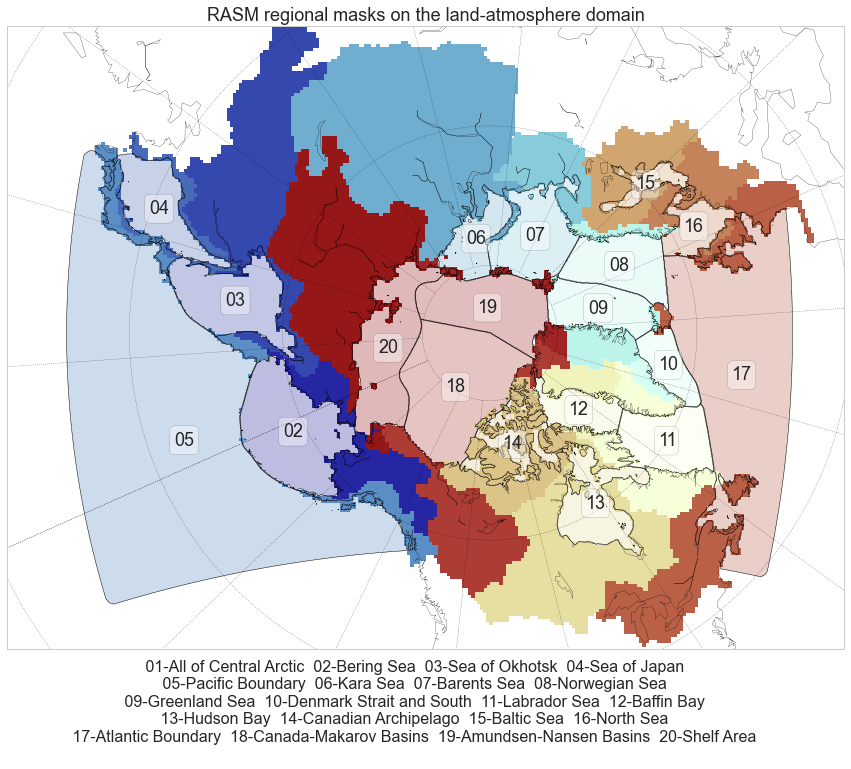

In [22]:
# Plot ocean drainage masks
fig, ax = plt.subplots(figsize=(15, 12))

m = Basemap(ax=ax, **projection)
xi, yi = m(np.squeeze(domain['xc'].values), np.squeeze(domain['yc'].values))
xio, yio = m(np.squeeze(ocn_masks['ULON'].values), np.squeeze(ocn_masks['ULAT'].values))

props = dict(boxstyle='round', facecolor='white', alpha=0.4)

for mask, key in ocean_mask_ncvars.items():
    
    if mask is not 'mask_centralarctic':
    
        color = ocean_mask_colors[key]

        sp = m.contourf(xi, yi, np.ma.masked_where(contrib_area_masks[mask] <= 0., contrib_area_masks[mask]),
                        levels=[0, 1.1], colors=[color, color], alpha=1.)        
        sp = m.contourf(xio, yio, np.ma.masked_where(ocn_masks[mask].values == 0, ocn_masks[mask].values),
                          levels=[0, 1.1], colors=[color, color], alpha=0.3)
        sp = m.contour(xio, yio, ocn_masks[mask].values,
                          levels=[0, 1.1], colors='black', linewidths=0.5)
        # Add text label
        ly, lx = center_of_mass(ocn_masks[mask].values)       
        ax.text(xio[ly, lx], yio[ly, lx], key, fontsize=18, fontweight='roman',
                 horizontalalignment='center', verticalalignment='center',
                 bbox=props)
        # put labels on c.o.m of drainage basins
#         ly, lx = center_of_mass(contrib_area_masks[mask])
#         plt.text(xi[ly, lx], yi[ly, lx], key, fontsize=18, fontweight='roman',
#                  horizontalalignment='center', verticalalignment='center',
#                  bbox=props)       
        
m.drawparallels(np.arange(-80., 81., 20.), linewidth=0.25)
m.drawmeridians(np.arange(-180., 181., 20.), linewidth=0.25)
m.drawcoastlines(color='k', linewidth=0.25)

ax.set_title('RASM regional masks on the land-atmosphere domain', fontsize=18)

string = ''
count = 0
for i in range(1, 21):
    key = "{0:02}".format(i)
    string += " {0}-{1} ".format(key, ocean_mask_names[key])
    count += 1
    if count > 3:
        string += '\n'
        count = 0.

fig.text(0.5, .14, string,
         horizontalalignment = 'center',
         verticalalignment = 'top',
         multialignment = 'center',
         fontsize=16)

fig.savefig('rasm_ocean_drainage_basins.pdf', format='pdf', )

In [23]:
# current_palette = sns.color_palette(n_colors=9)
# sns.palplot(current_palette)
# def rgb_to_hex(rgb):
#     return '#%02x%02x%02x' % rgb

# for rgb in current_palette:
#     temp = (256*rgb[0], 256*rgb[1], 256*rgb[2])
#     print(rgb_to_hex(temp))
    
drainage_basin_names = {'01': 'Yukon',
                        '02': 'Kolyma',
                        '03': 'Lena',
                        '04': 'Yenisey',
                        '05': 'Ob',
                        '06': 'St. Lawrence',
                        '07': 'Nelson',
                        '08': 'Mackenzie',
                        '09': 'Amur',
                        '10': 'RVIC Drainage'}

drainage_basin_colors = {'01': '#4c72b0',
                         '02': '#64b5cd',
                         '03': '#55a868',
                         '04': '#ccb974',
                         '05': '#4c72b0',
                         '06': '#55a868',
                         '07': '#8172b2',
                         '08': '#c44e52',
                         '09': '#c44e52',
                         '10': 'lightgrey'}

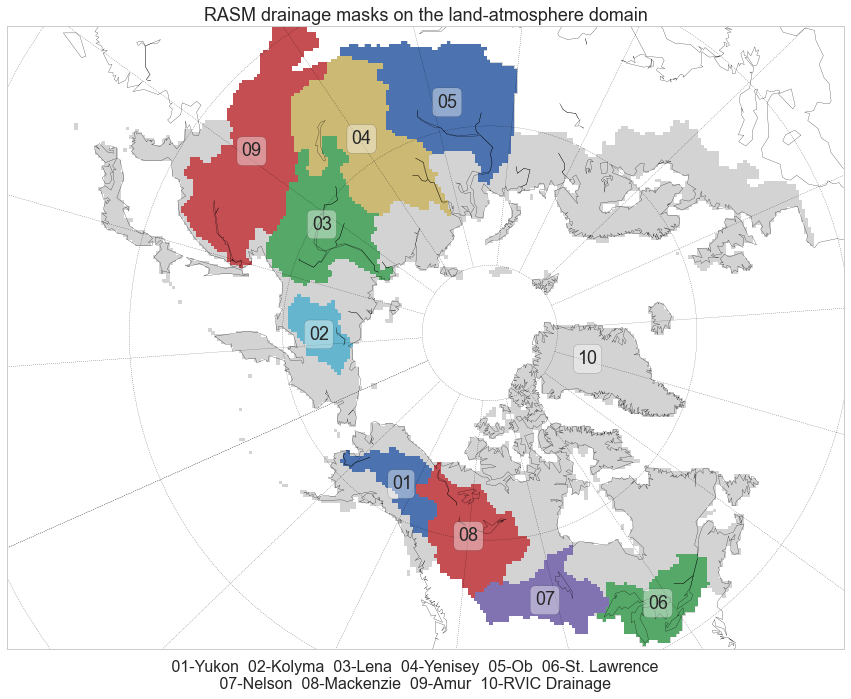

In [24]:
# Plot the drainage basin masks

fig, ax = plt.subplots(figsize=(15, 12))

m = Basemap(ax=ax, **projection)
xi, yi = m(np.squeeze(domain['xc'].values), np.squeeze(domain['yc'].values))

sp = m.contourf(xi, yi, np.ma.masked_where(rvic_frac <= 0., rvic_frac),
                levels=[0, 1.1], colors=[drainage_basin_colors['10'], drainage_basin_colors['10']], alpha=1.)
ly = 95
lx = 190
ax.text(xi[ly, lx], yi[ly, lx], '10', fontsize=18, fontweight='roman',
         horizontalalignment='center', verticalalignment='center',
         bbox=props)
for key, mask in drainage_basin_names.items():
    if mask != 'RVIC Drainage':
        
        sp = m.contourf(xi, yi, np.ma.masked_where(basin_masks[mask] <= 0., basin_masks[mask]),
                        levels=[0, 1.1], colors=[drainage_basin_colors[key], drainage_basin_colors[key]], alpha=1.)
        
        ly, lx = center_of_mass(basin_masks[mask])       
        ax.text(xi[ly, lx], yi[ly, lx], key, fontsize=18, fontweight='roman',
                 horizontalalignment='center', verticalalignment='center',
                 bbox=props)
        
m.drawparallels(np.arange(-80., 81., 20.), linewidth=0.25)
m.drawmeridians(np.arange(-180., 181., 20.), linewidth=0.25)
m.drawcoastlines(color='k', linewidth=0.25)

ax.set_title('RASM drainage masks on the land-atmosphere domain', fontsize=18)

string = ''
count = 0
for i in range(1, 11):
    key = "{0:02}".format(i)
    string += " {0}-{1} ".format(key, drainage_basin_names[key])
    count += 1
    if count > 5:
        string += '\n'
        count = 0.

fig.text(0.5, .14, string,
         horizontalalignment = 'center',
         verticalalignment = 'top',
         multialignment = 'center',
         fontsize=16)
fig.savefig('rasm_major_rivers.pdf', format='pdf', )

In [25]:
biome_colors = {'04': '#8172b2',
                '05': '#64b5cd',
                '06': '#55a868',
                '08': '#ccb974',
                '11': '#4c72b0',
                '13': '#c44e52',
                '99': 'lightgrey'}

biome_names = {'04': 'Temperate Broadleaf and Mixed Forests',
               '05': 'Temperate Coniferous Forests',
               '06': 'Boreal Forests/Taiga',
               '08': 'Temperate Grasslands, Savannas, and Shrublands',
               '11': 'Tundra',
               '13': 'Deserts and Xeric Shrublands',
               '99': 'Rock and Ice'}

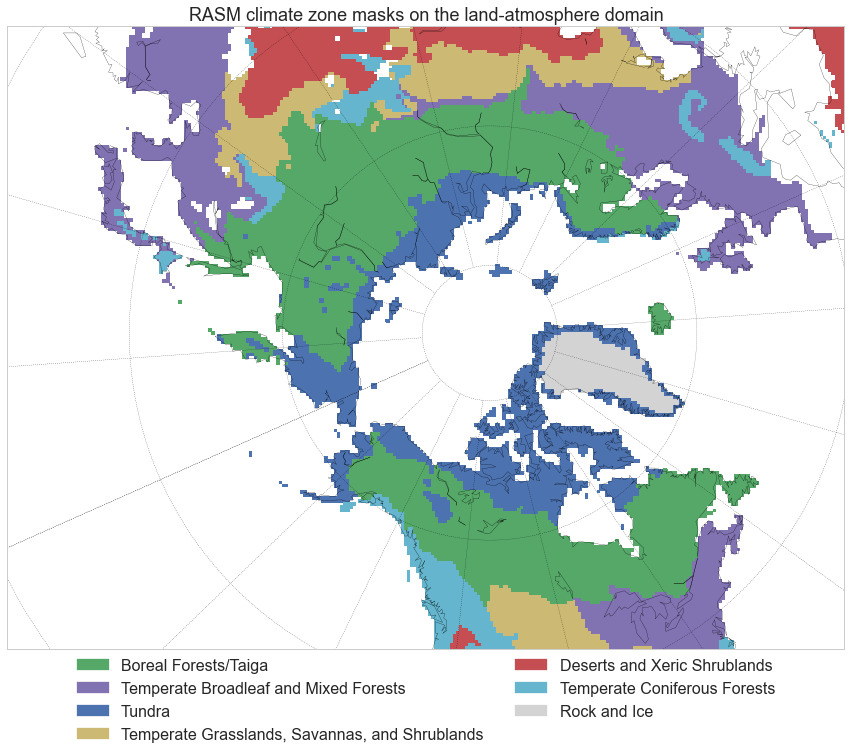

In [26]:
# Plot the climate zone masks

ranking = OrderedDict()

fig, ax = plt.subplots(figsize=(15, 12))

m = Basemap(ax=ax, **projection)
xi, yi = m(np.squeeze(domain['xc'].values), np.squeeze(domain['yc'].values))

for key, color in biome_colors.items():
    
    biome = 'biome_{0}'.format(int(key))
        
    sp = m.contourf(xi, yi, np.ma.masked_where(scaled_biomes[biome] <= 0., scaled_biomes[biome]),
                    levels=[0, 1.1], colors=[color, color], alpha=1.)
    
    ranking[key] = np.nansum(scaled_biomes[biome])
        
m.drawparallels(np.arange(-80., 81., 20.), linewidth=0.25)
m.drawmeridians(np.arange(-180., 181., 20.), linewidth=0.25)
m.drawcoastlines(color='k', linewidth=0.25)

ax.set_title('RASM climate zone masks on the land-atmosphere domain', fontsize=18)

order = sorted(ranking, key=ranking.get, reverse=True)
patches = []
for key in order:
    patches.append(mpatches.Patch(color=biome_colors[key], label=biome_names[key]))
    
plt.legend(handles=patches, loc=8, fontsize=16, ncol=2,
           bbox_to_anchor=(0.5, -.16), borderaxespad=0.)

fig.savefig('rasm_biomes.pdf', format='pdf', )

In [29]:
long_names = {'mask_amur': 'Amur River basin drainage mask',
              'mask_ob': 'Ob River basin drainage mask',
              'mask_yenisey': 'Yenisey River basin drainage mask',
              'mask_lena': 'Lena River basin drainage mask',
              'mask_mackenzie': 'Mackenzie River basin drainage mask',
              'mask_nelson': 'Nelson River basin drainage mask',
              'mask_st_lawrence': 'St. Lawrence drainage mask River basin',
              'mask_yukon': 'Yenisey River basin drainage mask',
              'mask_kolyma': 'Kolyma River basin drainage mask',
              'mask_rvic_drainage': 'RVIC to POP drainage mask',
              'mask_temperate_grasslands_savannas_and_shrublands': 'emperate grasslands, savannas, and shrublands ecoregion mask',
              'mask_deserts_and_xeric_shrublands': 'deserts and xeric shrublands ecoregion',
              'mask_rock_and_ice': 'rock and ice ecoregion mask',
              'mask_tundra': 'tundra ecoregion mask',
              'mask_temperate_broadleaf_and_mixed_forests': 'temperate brodleaf and mixed forests ecoregion mask',
              'mask_temperate_coniferous_forests': 'temperate coniferous forests ecoregion mask',
              'mask_boreal_forests_taiga': 'boreal forests / taiga ecoregion mask',
              'mask_rof_to_archipelago': 'land mask draining to the Canadian Archipelago ocean basin',
              'mask_rof_to_atlantic': 'land mask draining to the Atlantic ocean basin',
              'mask_rof_to_baffin': 'land mask draining to the Baffin ocean basin',
              'mask_rof_to_baltic': 'land mask draining to the Baltic ocean basin',
              'mask_rof_to_barents': 'land mask draining to the Barents ocean basin',
              'mask_rof_to_bering': 'land mask draining to the Bearing ocean basin',
              'mask_rof_to_canada': 'land mask draining to the Canada ocean basin',
              'mask_rof_to_centralarctic': 'land mask draining to the Central Arctic ocean basin',
              'mask_rof_to_denmarkstrait': 'land mask draining to the Denmark Strait ocean basin',
              'mask_rof_to_greenland': 'land mask draining to the Greenland ocean basin',
              'mask_rof_to_hudsonbay': 'land mask draining to the Hudson Bay ocean basin',
              'mask_rof_to_japan': 'land mask draining to the Japan ocean basin',
              'mask_rof_to_kara': 'land mask draining to the Kara ocean basin',
              'mask_rof_to_labrador': 'land mask draining to the Labrador ocean basin',
              'mask_rof_to_nansen': 'land mask draining to the Nansen ocean basin',
              'mask_rof_to_northsea': 'land mask draining to the Northsea ocean basin',
              'mask_rof_to_norwegian': 'land mask draining to the Norwegian ocean basin',
              'mask_rof_to_okhotsk': 'land mask draining to the Okhotsk ocean basin',
              'mask_rof_to_pacific': 'land mask draining to the Pacific ocean basin',
              'mask_rof_to_shelf': 'land mask draining to the Siberian Shelf ocean basin',
              'mask_active_land': 'land mask with 6 border grid cells removed',
              'mask_active_atmosphere': 'atmosphere mask with 6 border grid cells removed'}

In [32]:
# Write output netCDF mask file

copyfile(domain_file, new_mask_file)
print(domain_file, new_mask_file)
f = Dataset(new_mask_file, mode='a')

# Write Largest River Basin Masks
for key, data in basin_masks.items():
    name = 'mask_{0}'.format(key.replace(' ', '_').replace('.', '').lower())
    print(name)
    v = f.createVariable(name, 'f8', dimensions=('nj', 'ni'))
    v[:] = data
    v.long_name = long_names[name]
    v.units = 'fraction'
    v.source = os.path.basename(rvic_param_file)
    v.description = 'river basin mask upstream of coastal outlet'

# Write RVIC Drainage Basin Mask
name = 'mask_rvic_drainage'
v = f.createVariable(name, 'f8', dimensions=('nj', 'ni'))
print(name)
v[:] = rvic_frac
v.long_name = long_names[name]
v.units = 'fraction'
v.source = os.path.basename(rvic_param_file)
v.description = 'active rvic land fractions'

# Write Ecoregions Masks
for key, longname in biome_names.items():
    biome = 'biome_{0}'.format(int(key))
    name = 'mask_{0}'.format(longname.lower().replace(' ', '_').replace(',', '').replace('/', '_'))
    print(name)
    v = f.createVariable(name, 'f8', dimensions=('nj', 'ni'))
    v[:] = scaled_biomes[biome]
    v.long_name = long_names[name]
    v.units = 'fraction'
    v.source = 'Global Ecoregions, Olson, D. M. and E. Dinerstein (2002). Distributed by the Nature Conservancy'
    v.description = '{0} - ECO_NUM: {1}'.format(longname, key)

# Write Ocean Drainage Basin Masks
for key, data in contrib_area_masks.items():
    name = 'mask_rof_to_{0}'.format(key[5:])
    print(name)
    v = f.createVariable(name, 'f8', dimensions=('nj', 'ni'))
    v[:] = data
    v.long_name = long_names[name]
    v.units = 'fraction'
    v.source = os.path.basename(rvic_param_file)
    v.description = 'land mask draining to {0}'.format(key)

# write inner atmosphere / land mask
n = 6
data = domain['frac'].values[:]
data[:n, :] = 0.
data[-n:, :] = 0.
data[:, :n] = 0.
data[:, -n:] = 0.
name = 'mask_active_land'
v = f.createVariable(name, 'f8', dimensions=('nj', 'ni'))
print(name)
v[:] = data
v.long_name = long_names[name]
v.units = 'fraction'
v.description = 'land fractions with {0} border cells masked out'.format(n)

data = np.ones_like(domain['frac'].values)
data[:n, :] = 0.
data[-n:, :] = 0.
data[:, :n] = 0.
data[:, -n:] = 0.
name = 'mask_active_atmosphere'
v = f.createVariable(name, 'f8', dimensions=('nj', 'ni'))
print(name)
v[:] = data
v.long_name = long_names[name]
v.units = 'fraction'
v.description = 'atmosphere domain with {0} border cells masked out'.format(n)

for attr in ['source_code', 'SVN_url', 'history', 'map_grid_file_ocn',
             'map_grid_file_atm', 'output_file1', 'output_file2',
             'user_comment']:
    delattr(f, attr)

f.title = 'RASM land and rof masks and metrics'
f.history = 'Created by jhamman, {0}'.format(today)
f.source = 'RASM_land_masks.ipynb'

f.map_grid_file_lnd = os.path.basename(domain_file)
f.map_grid_file_ocn = os.path.basename(ocean_domain_file)
f.rvic_param_file = os.path.basename(rvic_param_file)
f.rof2ocn_map_file = os.path.basename(r2o_map_file)

f.close()

/Users/jhamman/Dropbox/RASM_Joe/domain.lnd.wr50a_ar9v4.100920.nc /Users/jhamman/workdir/rasm_land_masks.20150223.nc
mask_amur
mask_ob
mask_yenisey
mask_lena
mask_mackenzie
mask_nelson
mask_st_lawrence
mask_yukon
mask_kolyma
mask_rvic_drainage
mask_temperate_grasslands_savannas_and_shrublands
mask_temperate_broadleaf_and_mixed_forests
mask_rock_and_ice
mask_tundra
mask_temperate_coniferous_forests
mask_boreal_forests_taiga
mask_deserts_and_xeric_shrublands
mask_rof_to_archipelago
mask_rof_to_atlantic
mask_rof_to_baffin
mask_rof_to_baltic
mask_rof_to_barents
mask_rof_to_bering
mask_rof_to_canada
mask_rof_to_centralarctic
mask_rof_to_denmarkstrait
mask_rof_to_greenland
mask_rof_to_hudsonbay
mask_rof_to_japan
mask_rof_to_kara
mask_rof_to_labrador
mask_rof_to_nansen
mask_rof_to_northsea
mask_rof_to_norwegian
mask_rof_to_okhotsk
mask_rof_to_pacific
mask_rof_to_shelf
mask_active_land
mask_active_atmosphere
